In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/dataset/tweet-sentiment-extraction/tweet-sentiment-extraction.csv')

In [ ]:
data.drop(columns=['textID'],inplace=True)

In [ ]:
data

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,my boss is bullying me...,bullying me,negative
3,what interview! leave me alone,leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...
27476,wish we could come see u on Denver husband l...,d lost,negative
27477,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,But it was worth it ****.,But it was worth it ****.,positive


In [ ]:
data['sentiment'].value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [ ]:
new_data=data.drop(314)

In [ ]:
data1=new_data.reset_index()

In [ ]:
list1=[]
for i in data1['text']:
  list1.append(i.lstrip())

In [ ]:
data1['text1']=list1

In [ ]:
data1.drop(columns=['index','text'],inplace=True)


In [ ]:
list2=[]
for i,j in  zip(data1['text1'],data1['selected_text']):
  k=j.split()
  list2.append(i.find(k[0]))

In [ ]:
list3=[]
for i in list2:
  list3.append(i+1)

In [ ]:
list4=[]
for i in data1['selected_text']:
  k=len(i)
  list4.append(k)


In [ ]:
data1['sentiment'].replace({'neutral':1,'positive':2,'negative':0},inplace=True)

In [ ]:
import re
def preprocess(w):
  w=w.lower()
  w=w.strip()
  return w

In [ ]:
data1['preprocesed1']=list(map(preprocess,data1['text1']))
data1['preprocesed2']=list(map(preprocess,data1['selected_text']))

In [ ]:
data1.drop(columns=['selected_text','text1'],inplace=True)

In [ ]:
! pip install transformers
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
enn=tokenizer(data1['preprocesed1'].to_list(),max_length=64,truncation=True,padding=True)

In [ ]:
tokenizer.get_vocab

<bound method PreTrainedTokenizerFast.get_vocab of PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})>

In [ ]:
def add_token_positions(encodings, answers,ending):
    start_positions = []
    end_positions = []
    newww={}
    for i in range(len(answers[:-1])):
        start_positions.append(encodings.char_to_token(i, answers[i]))
        end_positions.append(encodings.char_to_token(i+1, ending[i]))
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
          
        
        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, ending[i] + 1)
    newww.update({'start_positions': start_positions, 'end_positions': end_positions})
    return newww

b=add_token_positions(enn,list2,list4)

In [ ]:
j=0
for i in b['start_positions']:
  if i==None:
    j+=1
j

In [ ]:
k=0
for i in b['end_positions']:
  if i==None:
    k+=1
k

7469

In [ ]:
ll=[]
for i in enn['input_ids']:
  ll.append(i)

In [ ]:
def create_model():
  xx1=tf.keras.layers.Input(shape=(3,),dtype=tf.float32,name='i2')
  x1=tf.keras.layers.Input(shape=(64,),dtype=tf.float32,name='i1')
  x=tf.keras.layers.Embedding(30522,256,mask_zero=True)(x1)
  x=tf.keras.layers.LSTM(2048,activation='tanh',return_sequences=True,recurrent_dropout=0.3,kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
  for i in range(8):
    x=tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    attention_output=tf.keras.layers.MultiHeadAttention(num_heads=8,key_dim=64,dropout=0.1)(x,x)
    x = tf.keras.layers.Add()([attention_output,x])
    x5=tf.keras.layers.Dense(256,activation='relu')(x)
  representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x5)
  representation = tf.keras.layers.Flatten()(representation)
  representation = tf.keras.layers.Dropout(0.5)(representation)
  features=tf.keras.layers.Dense(128,activation='relu')(representation)
  x2=tf.keras.layers.Dense(256,activation='relu')(xx1)
  x2=tf.keras.layers.Dropout(0.4)(x2)
  x2=tf.keras.layers.Dense(128,activation='relu')(x2)
  f_x=tf.keras.layers.concatenate([features,x2])
  f_x=tf.keras.layers.Dense(64,activation='relu')(f_x)
  final1=tf.keras.layers.Dense(64,activation='softmax')(f_x)
  final2=tf.keras.layers.Dense(64,activation='softmax')(f_x)
  model=tf.keras.models.Model(inputs=[x1,xx1],outputs=[final1,final2])
  return model

In [ ]:
model1=create_model()

In [ ]:
model1.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i1 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 64, 256)      7813632     i1[0][0]                         
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 64, 2048)     18882560    embedding_7[0][0]                
__________________________________________________________________________________________________
layer_normalization_63 (LayerNo (None, 64, 2048)     4096        lstm_7[0][0]                     
____________________________________________________________________________________________

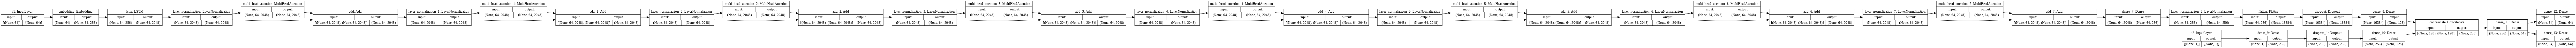

In [ ]:
tf.keras.utils.plot_model(model = model1 , rankdir="LR", dpi=72, show_shapes=True)

In [ ]:
startt=b['start_positions']
endd=b['end_positions']

In [ ]:
len(startt)

27479

In [ ]:
len(endd)

27479

In [ ]:
v2= tf.keras.utils.to_categorical(v2, 3)

In [ ]:
v1=enn['input_ids'][:10000]
v1=np.array(v1)
v2=data1['sentiment'][:10000]
v2 = np.asarray(v2).astype(np.float32)
v3=startt[:10000]
v3 = np.asarray(v3).astype(np.float32)
v4=endd[:10000]
v4 = np.asarray(v4).astype(np.float32)

In [ ]:
j=0
v5=[]
for i in v4:
  if i==None:
    v5.append(-1)
  else:
    v5.append(i)

In [ ]:
v5 = np.asarray(v5).astype(np.float32)

In [ ]:
loss1 =tf.keras.losses.SparseCategoricalCrossentropy()
loss2 =tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model1.compile(optimizer=optimizer, loss=[loss1,loss2])

In [ ]:
model1.fit(x=[v1,v2],y=[v3,v5],batch_size=32,epochs=3)